# Proyecto: Modelos de predicción y sistemas de recomendación

Curso: Temas Especiales de inteligencia artificial: Desarrollo de Herramientas para Aprendizaje de Máquina

## Introducción

Durante la primera fase de este proyecto se construirá un modelo de predicción en base a un conjunto de datos de MovieLens. Este conjunto de datos contiene las evaluaciones que dan distintos usuarios a peliculas, lo que se busca con este modelo es predecir la evaluación que un usuario daría a una película. Para ellos se van a comparar dos modelos de predicción: arboles de decisión y redes neuronales para identificar cual de ellos genera los mejores resultados.

Durante la segunda fase del actual proyecto se pretende construir un sistema de recomendación en base al mejor modelo obtenido anteriormente para compararlo contra el modelo *k-nearest neighbors*. Posteriormente, a partir de ambos modelos, se construirá un sistema de recomandación que permita recomendar a un usuario un conjunto de películas de acuerdo a sus gustos.

## Presentación de datos

El conjunto de datos a utilizar esta compuesto por 6 archivos principales. Cada uno de ellos se describe a continuación:

- u.data: Contiene cada una de las evaluaciones dadas. Este archivo contiene solo los identificadores de los usuario y las peliculas, mas no la información de ellos.
- u.genre: Contiene cada uno de los géneros del conjunto de datos con su respectivo identificador.
- u.info: Contiene información general del conjunto de datos.
- u.item: Contiene una descripción detallada de las películas siendo evaluadas con su respectivo identificador.
- u.occupation: Contiene una descripción más detallada de las ocupaciones de los usuarios.
- u.user: Contiene más detalles de los usuarios evaluadores.

A continuación se carga el conjunto de datos. Y se muestra un fragmento de cada uno de estos conjuntos.

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
data_path = '/content/drive/My Drive/IA_Compartida/Proyecto 2 y 3/ml-100k/'

u_data = pd.read_csv(data_path + 'u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])
u_genre = pd.read_csv(data_path + 'u.genre', sep='|', header=None, names=['genre', 'genre_id'])
u_info = pd.read_csv(data_path + 'u.info', sep=' ', header=None, names=['info', 'value'])
u_item = pd.read_csv(data_path + 'u.item', sep='|', header=None, names=['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], encoding='latin-1')
u_occupation = pd.read_csv(data_path + 'u.occupation', sep='|', header=None, names=['occupation'])
u_user = pd.read_csv(data_path + 'u.user', sep='|', header=None, names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

# Mostrar una muestra de cada DataFrame
print('Muestra del archivo u.data')
print(u_data.head())
print('----------------------------------------------------------------------------')
print('Muestra del archivo u.genre')
print(u_genre.head())
print('----------------------------------------------------------------------------')
print('Muestra del archivo u.info')
print(u_info.head())
print('----------------------------------------------------------------------------')
print('Muestra del archivo u.item')
print(u_item.head())
print('----------------------------------------------------------------------------')
print('Muestra del archivo u.occupation')
print(u_occupation.head())
print('----------------------------------------------------------------------------')
print('Muestra del archivo u.user')
print(u_user.head())

Mounted at /content/drive
Muestra del archivo u.data
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
----------------------------------------------------------------------------
Muestra del archivo u.genre
        genre  genre_id
0     unknown         0
1      Action         1
2   Adventure         2
3   Animation         3
4  Children's         4
----------------------------------------------------------------------------
Muestra del archivo u.info
     info    value
0     943    users
1    1682    items
2  100000  ratings
----------------------------------------------------------------------------
Muestra del archivo u.item
   movie_id        movie_title release_date  video_release_date  \
0         1   Toy Story (1995)  01-Jan-1995                 NaN   
1         2   GoldenEye (1995)  01-Jan-1995   

La descripción del conjunto de datos nos indica que se cuenta con una muestra de 100000 evaluaciones a peliculas; sin embargo lo podemos comprobar obteniendo la cantidad de filas del archivo u.data tal como se muestra a continuación.

In [ ]:
print('Cantidad de evaluaciones:', u_data.shape[0])

Cantidad de evaluaciones: 100000


Igualmente, ya que los datos se encuentra almacenados en multiples archivos decidimos que para facilitar el analisis combinaremos todos los conjuntos en un solo conjunta para hacer todo el analisis sobre este único conjunto de datos que unifica todos los anteriores. A continuación se muestra el código necesario para hacer esto.

In [ ]:
data_joined = u_data.merge(u_item, how = 'left', left_on = 'item_id', right_on = 'movie_id').merge(u_user, how = 'left', on = 'user_id')

data_joined.head()

NameError: name 'u_data' is not defined

A partir de este conjunto de datos unificados se procede a hacer un analisis exploratorio de datos para luego continuar con la construcción del los modelos.

## Analisis exploratorio

El modelo a construir busca predecir la evaluación que un usuario le daría a una película, dado este caso de uso lo primero que queremos conocer es la cantidad de usuarios y peliculas distintas que se cuentan en el conjunto de datos. Estos valores los podemos obtener con el siguiente código.

In [ ]:
print(
    'Se cuenta con',
    u_user['user_id'].nunique(),
    'usuarios distintos y con',
    u_item['movie_id'].nunique(),
    'peliculas distintas')

Se cuenta con 943 usuarios distintos y con 1682 peliculas distintas


A partir de estos procedemos a realizar un analisis exploratorio de estos usuarios y estas películas para entender los datos y luego proceder a construir el modelo.

Lo primero que queremos evaluar es la distribución de las evaluaciones para identificar sus posibles valores y su distribución. Para ello podemos usar el siguiente código.

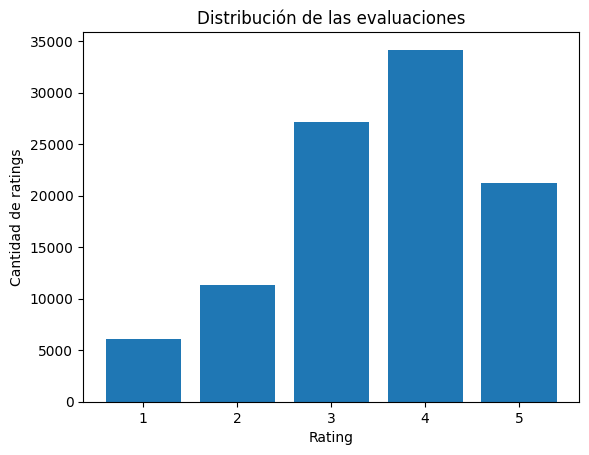

In [ ]:
import matplotlib.pyplot as plt

ratings_distribution = data_joined['rating'].value_counts()

plt.bar(ratings_distribution.index, ratings_distribution.values)
plt.xlabel('Rating')
plt.ylabel('Cantidad de ratings')
plt.title('Distribución de las evaluaciones')
plt.show()


En el gráfico anterior podemos ver que las evaluaciones se distribuyen mayormente en 4, 3 y 5.

Ya que conocemos la distribución de las evaluaciones nos interesa conocer esta distribución de evaluaciones por cada uno de los usuarios, peliculas y generos de las películas. Esto lo hacemos a continuación.

El usuario que más ratings tiene es 737 y el que menos tiene es 20 con una diferencia de 717


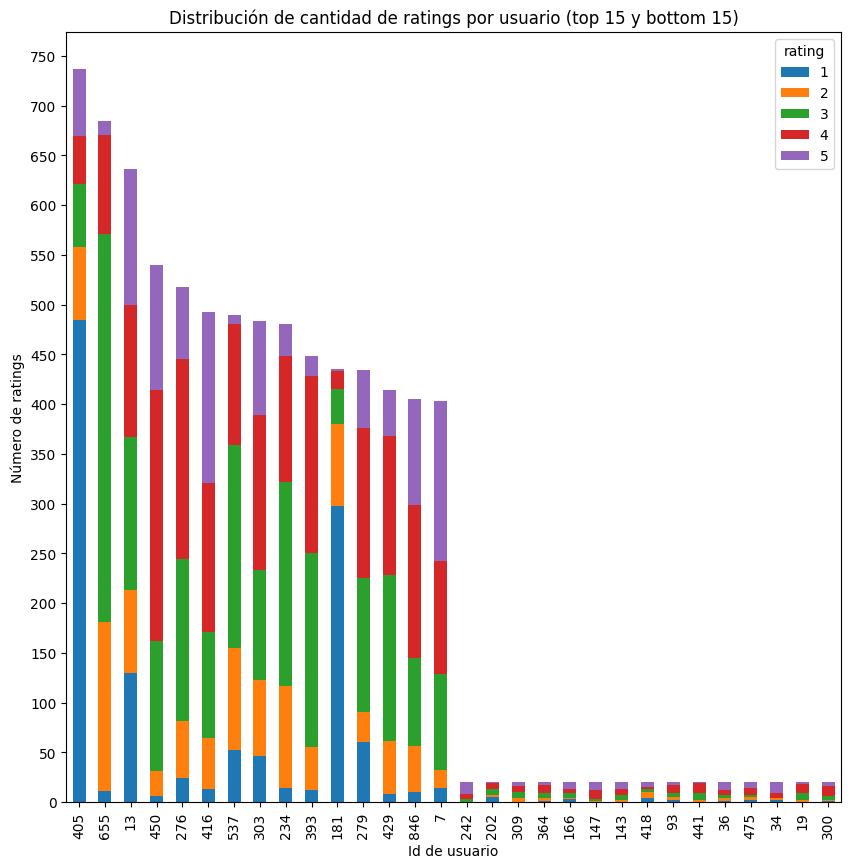

In [ ]:
import numpy as np

total_ratings_by_user = data_joined.groupby('user_id')['rating'].count()

top_10_users = total_ratings_by_user.nlargest(15).index
bottom_10_users = total_ratings_by_user.nsmallest(15).index

filtered_data = data_joined[data_joined['user_id'].isin(top_10_users.union(bottom_10_users))]

ratings_by_user = filtered_data.groupby('user_id')['rating'].value_counts()

sorted_ratings_by_user = ratings_by_user.unstack().loc[total_ratings_by_user.loc[top_10_users.union(bottom_10_users)].sort_values(ascending=False).index]
sorted_ratings_by_user.plot(kind='bar', stacked=True,figsize = (10, 10))
plt.xlabel('Id de usuario')
plt.ylabel('Número de ratings')
plt.title('Distribución de cantidad de ratings por usuario (top 15 y bottom 15)')
plt.yticks(np.arange(0, 751, step=50))


max_ratings = data_joined.groupby('user_id')['rating'].count().max()
min_ratings = data_joined.groupby('user_id')['rating'].count().min()
difference = max_ratings - min_ratings

print(f"El usuario que más ratings tiene es {max_ratings} y el que menos tiene es {min_ratings} con una diferencia de {difference}")



Al hacer el análisis de la cantidad de ratings que hacen los usuarios, podemos ver que existe una gran diferencia entre el top 25 y el bottom 25 de los usuarios, donde la diferencia más grande es de 717 reviews entre el que más ha colocado y el que menos.
También se puede apreciar como, el top 25 de usuarios con menos reviews ha hecho menos de 50 reviews.
Es interesante destacar como el usuario que más reviews ha colocado (737 en total) tiene casi 500 reviews con 1 de rating. Siendo él junto el usuario con id 181 las dos personas con más reviews negativas que nos encontramos. Estos dos usuarios podrían alterar significativamente las predicciones futuras que se puedan hacer en los modelos.

Text(0.5, 0, 'Edad del usuario')

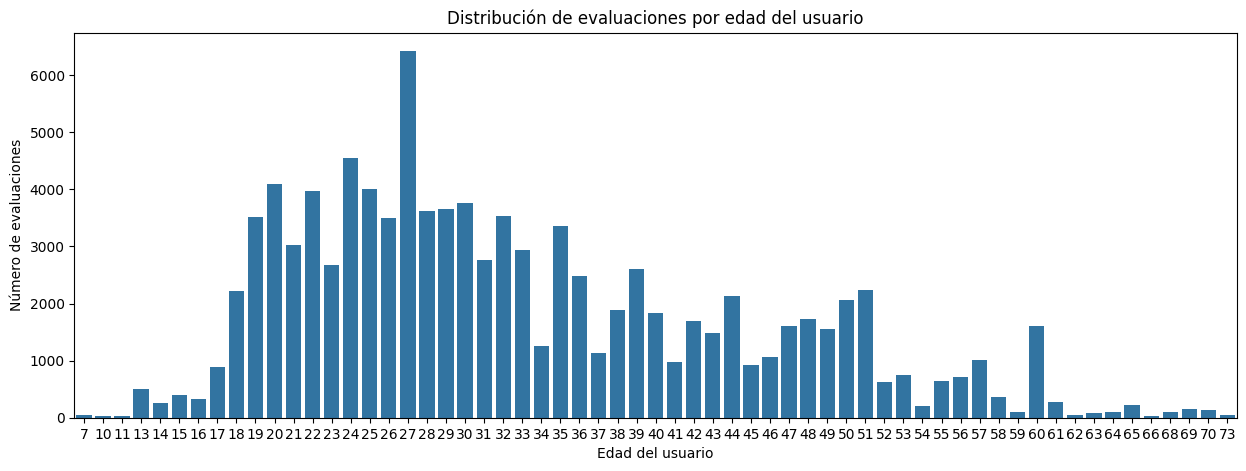

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_ratings_with_user_data = u_data.set_index('user_id').join(u_user.set_index('user_id'), on="user_id")
# df_ratings_with_user_data.hist('age', grid=False, bins=14)


plt.figure(figsize = (15, 5))

hist_data = data_joined['age'].sort_values().value_counts(sort=False).index
sns.countplot(data = data_joined, x = 'age', order = hist_data)

plt.title('Distribución de evaluaciones por edad del usuario')
plt.ylabel('Número de evaluaciones')
plt.xlabel('Edad del usuario')

A partir del gráfico anterior, se puede apreciar une distribución de evaluaciones basadas en la edad del usuario sesgada hacia la izquierda. El pico de la cantidad de evaluaciones se observa aproximadamente a los 30 años de edad.

---


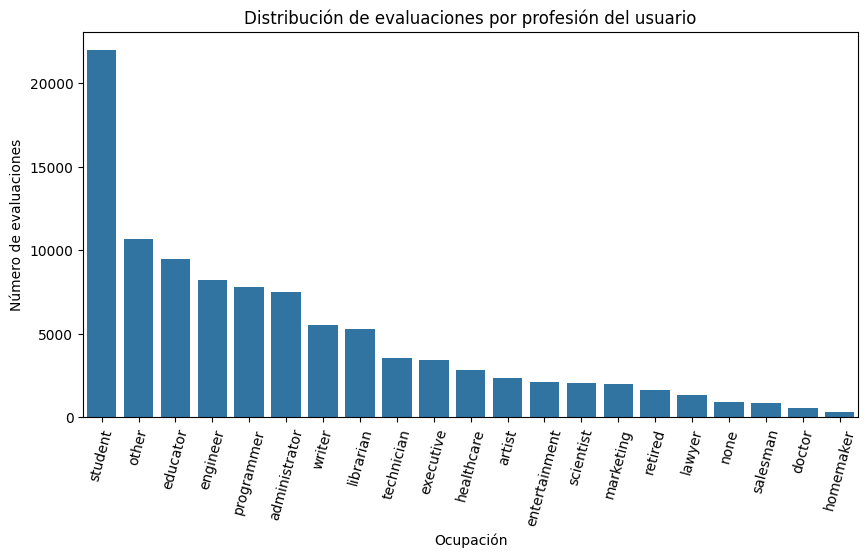

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10, 5))
sns.countplot(data = data_joined, x = 'occupation', order = data_joined['occupation'].value_counts().index)
plt.xticks(rotation = 75)
plt.xlabel("Ocupación")
plt.ylabel("Número de evaluaciones")
plt.title("Distribución de evaluaciones por profesión del usuario")
plt.show()

A partir del gráfico anterior podemos ver que la mayoria de la evaluaciones provienen de usuarios estudiantes, otros tipos de profesión o educadores.

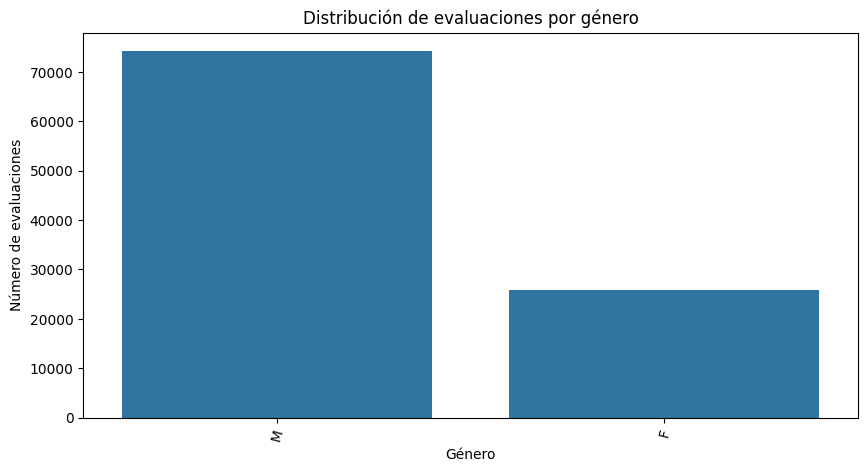

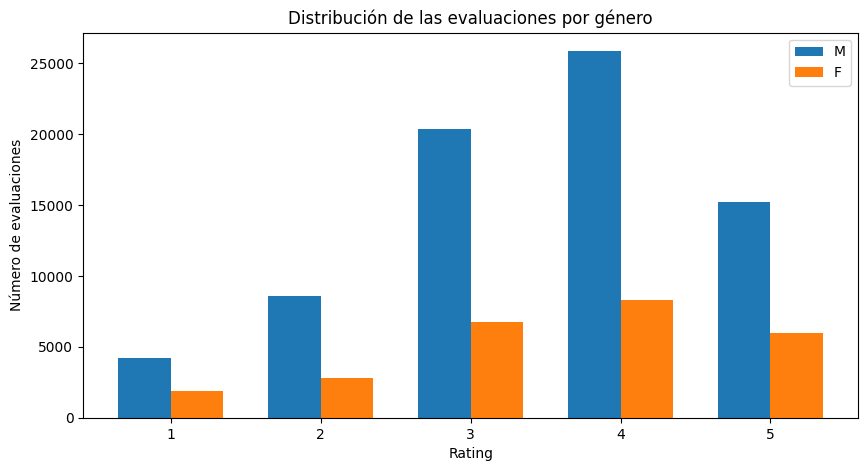

In [ ]:
plt.figure(figsize = (10, 5))
sns.countplot(data = data_joined, x = 'gender', order = data_joined['gender'].value_counts().index)
plt.xticks(rotation = 75)
plt.xlabel("Género")
plt.ylabel("Número de evaluaciones")
plt.title("Distribución de evaluaciones por género")
plt.show()

#Gráficos para la evaluación de género masculino
male_data = data_joined[data_joined['gender']=="M"]
male_rating_distribution = male_data['rating'].value_counts()
female_data = data_joined[data_joined['gender']=="F"]
female_rating_distribution = female_data['rating'].value_counts()
index = male_rating_distribution.index
bar_width = 0.35

plt.figure(figsize = (10, 5))
plt.bar(index - bar_width/2, male_rating_distribution.values, bar_width, label='M')
plt.bar(index + bar_width/2, female_rating_distribution.values, bar_width, label='F')
plt.xlabel('Rating')
plt.ylabel('Número de evaluaciones')
plt.title('Distribución de las evaluaciones por género')
plt.legend()
plt.show()




Se puede apreciar que existe una diferencia de casi 40mil evaluaciones entre el género masculino y femenino.
A pesar de esto, en el segundo gráfico podemos apreciar que la distribución que siguen los ratings es igual en ambos géneros yendo el ei siguiente orden:

-4

-3

-5

-2

-1


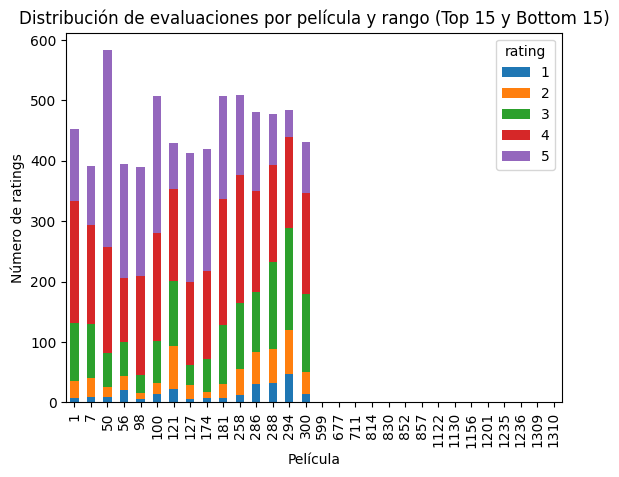

La diferencia entre la película con más ratings y la que menos tiene es de 582


In [ ]:
import matplotlib.pyplot as plt

total_ratings_by_movie = data_joined.groupby('movie_id')['rating'].count()

top_10_movies = total_ratings_by_movie.nlargest(15).index
bottom_10_movies = total_ratings_by_movie.nsmallest(15).index

filtered_data = data_joined[data_joined['movie_id'].isin(top_10_movies.union(bottom_10_movies))]

ratings_by_movie = filtered_data.groupby('movie_id')['rating'].value_counts()

ratings_by_movie.unstack().plot(kind='bar', stacked=True)
plt.xlabel('Película')
plt.ylabel('Número de ratings')
plt.title('Distribución de evaluaciones por película y rango (Top 15 y Bottom 15)')
plt.show()

max_ratings = data_joined.groupby('movie_id')['rating'].count().max()
min_ratings = data_joined.groupby('movie_id')['rating'].count().min()
difference = max_ratings - min_ratings

print(f"La diferencia entre la película con más ratings y la que menos tiene es de {difference}")


El gráfico anterior muestra la distribución de ratings por películas. Donde llama la atención la existencia de peliculas con muchas valoraciones y otras con muy pocas, siendo la mayor diferencia de 582 valoraciones. Esto indica que los datos para las películas que no tienen suficientes valoraciones podrían tener problemas.

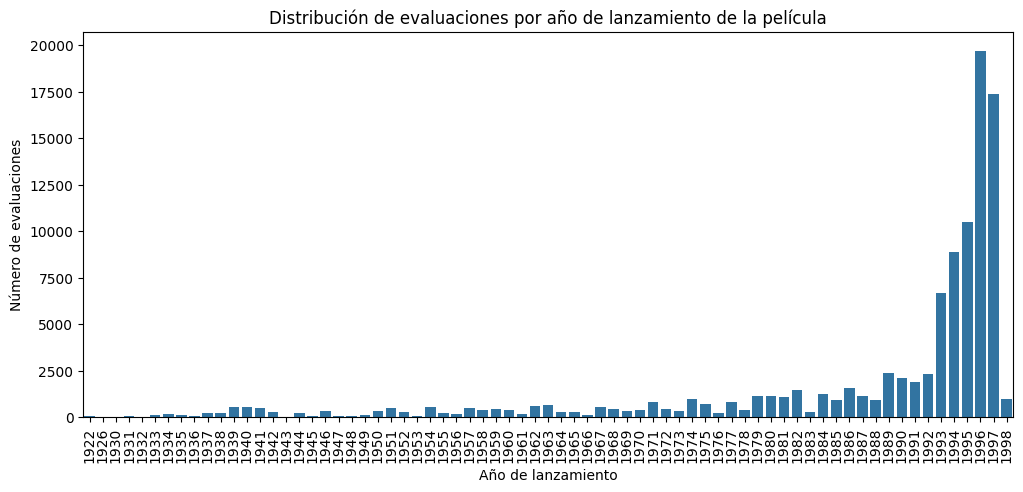

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurarse de que 'release_year' sea un int
data_joined['release_year'] = data_joined['release_date'].str.split('-').str[-1]
data_joined['release_year'] = pd.to_numeric(data_joined['release_year'], errors='coerce').astype('Int64')

# Eliminar filas con valores NaN en 'release_year' (si las hay)
data_joined = data_joined.dropna(subset=['release_year'])

# Ordenar los años de lanzamiento
release_year_order = sorted(data_joined['release_year'].dropna().unique())

plt.figure(figsize=(12, 5))
sns.countplot(data=data_joined, x='release_year', order=release_year_order)
plt.xticks(rotation=90)
plt.xlabel("Año de lanzamiento")
plt.ylabel("Número de evaluaciones")
plt.title("Distribución de evaluaciones por año de lanzamiento de la película")
plt.show()

A partir de los datos anteriores podemos ver que la mayoria de evaluaciones fueron realizadas a películas lanzadas entre el año 1993 y el 1997.

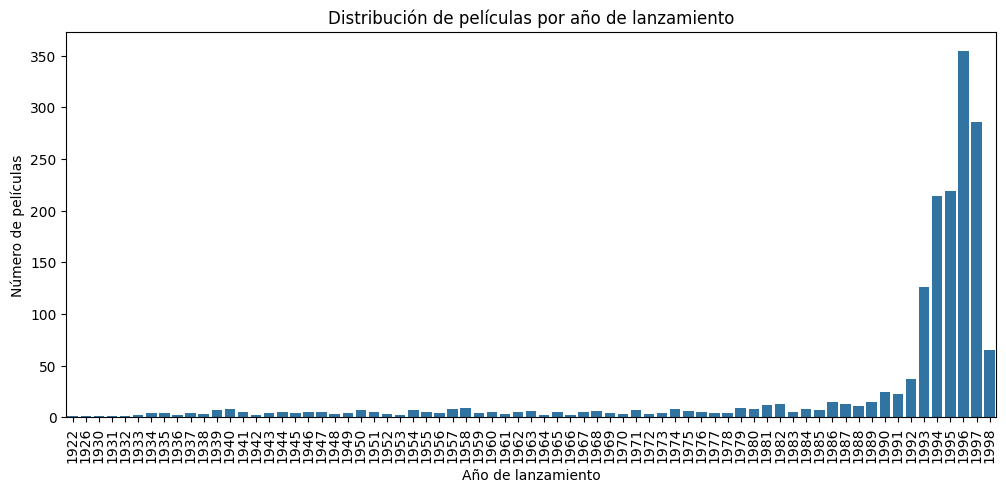

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegurarse de que 'release_year' sea un int
u_item['release_year'] = u_item['release_date'].str.split('-').str[-1]
u_item['release_year'] = pd.to_numeric(u_item['release_year'], errors='coerce').astype('Int64')

# Eliminar filas con valores NaN en 'release_year' (si las hay)
u_item = u_item.dropna(subset=['release_year'])

# Ordenar los años de lanzamiento
release_year_order = sorted(u_item['release_year'].dropna().unique())

plt.figure(figsize=(12, 5))
sns.countplot(data=u_item, x='release_year', order=release_year_order)
plt.xticks(rotation=90)
plt.xlabel("Año de lanzamiento")
plt.ylabel("Número de películas")
plt.title("Distribución de películas por año de lanzamiento")
plt.show()


Sin embargo, a partir de conjunto de datos de peliculas podemos ver que la mayoría de las películas del conjunto de datos son películas lanzadas igualmente entre los años 1993 y 1997. Esto podría justificar el porque la mayoria de evaluaciones se dieron sobre películas lanzadas en estos años, es donde hay mayor presencia de datos.

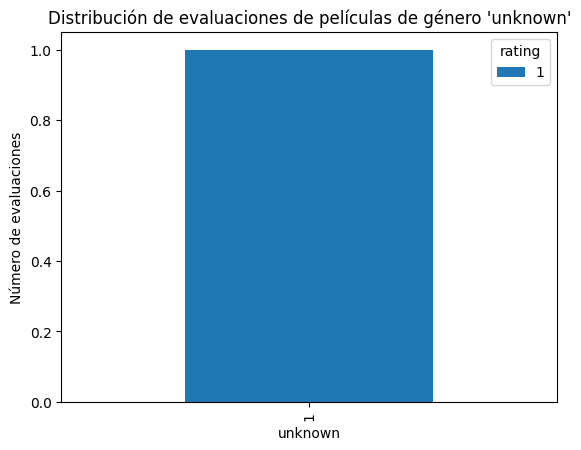

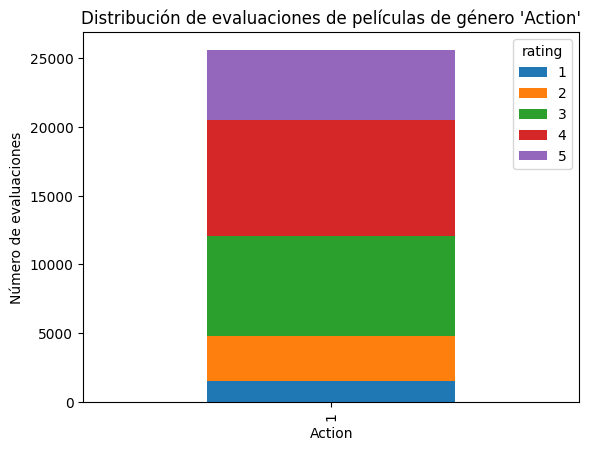

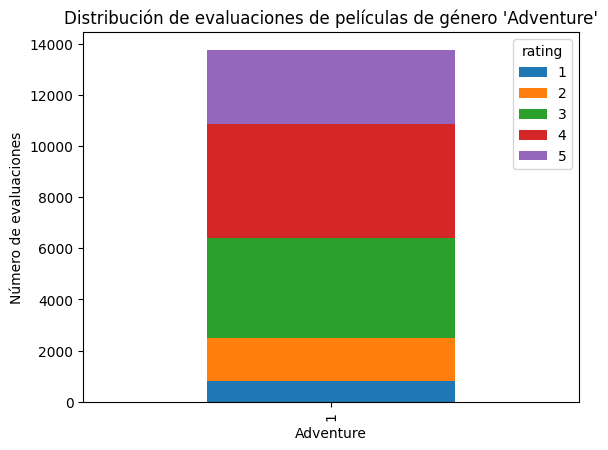

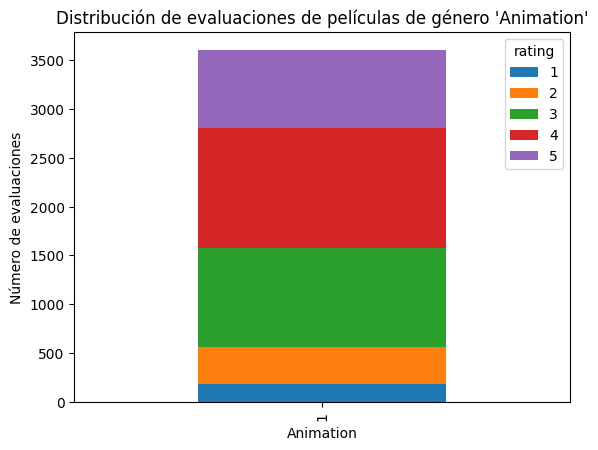

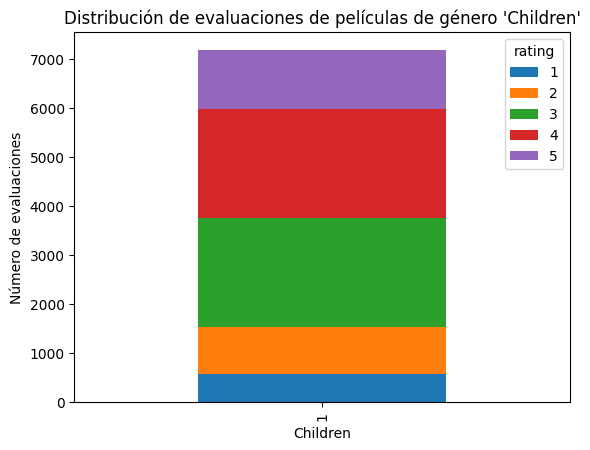

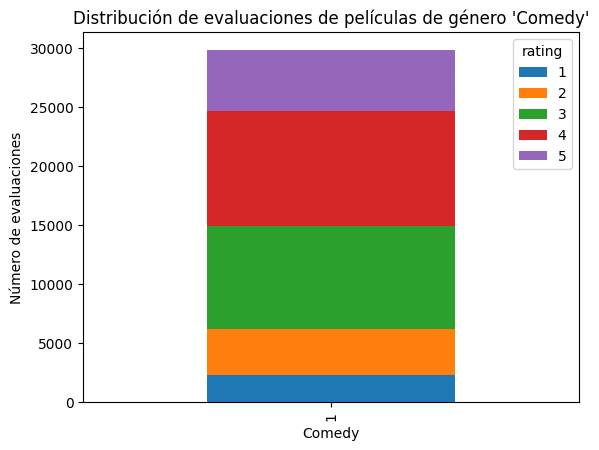

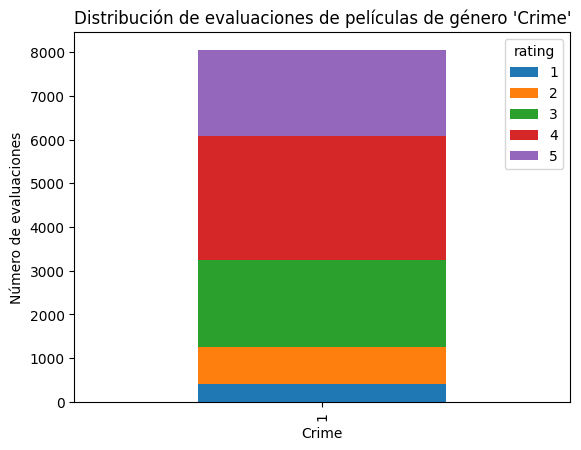

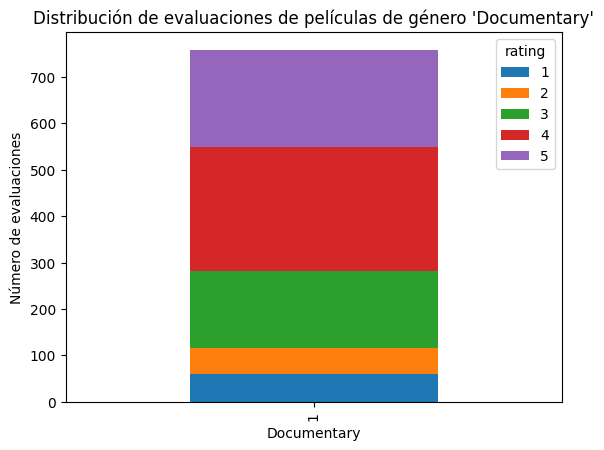

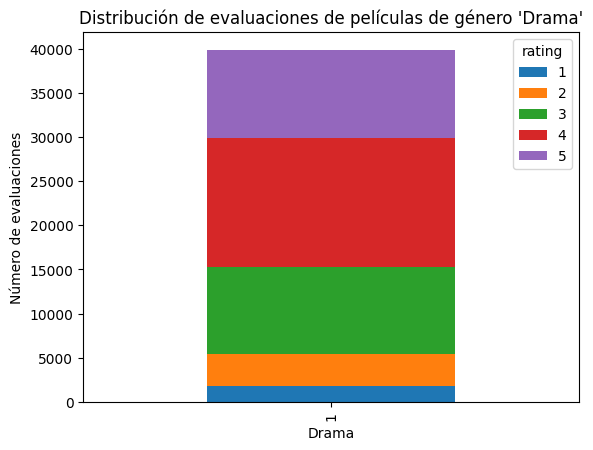

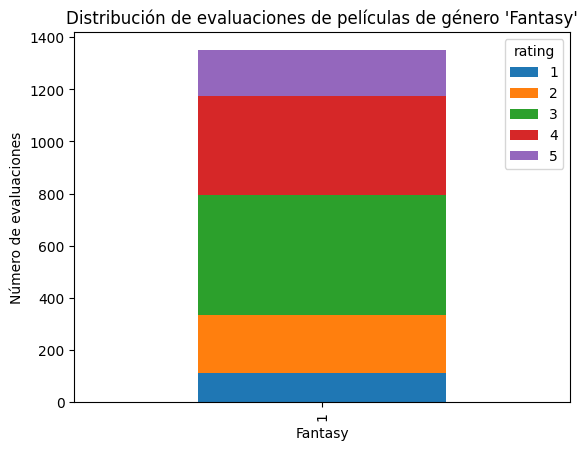

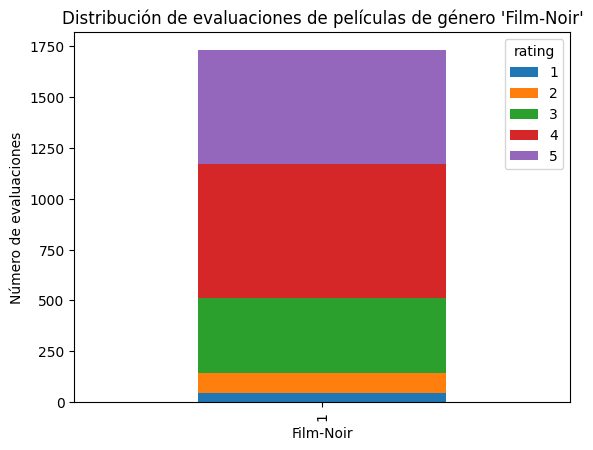

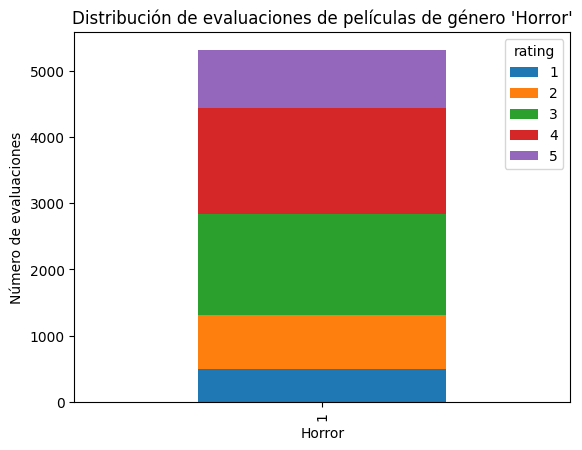

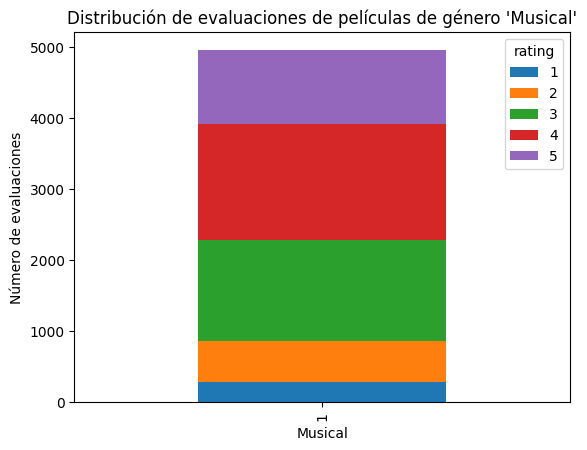

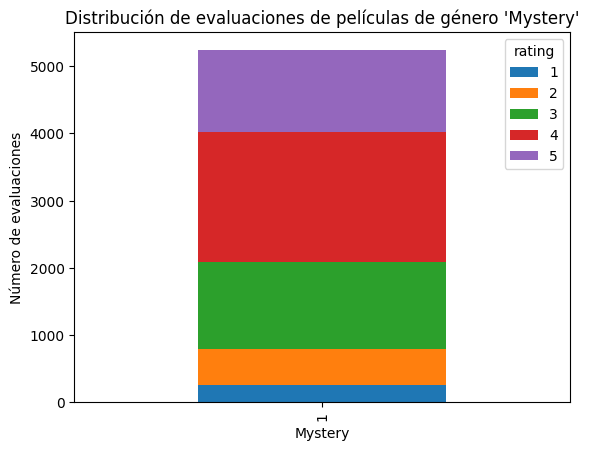

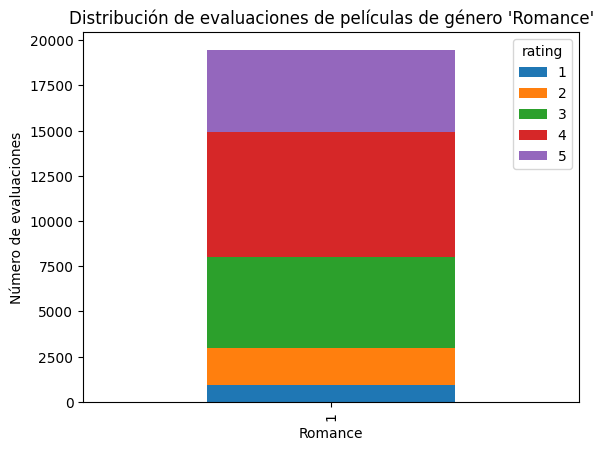

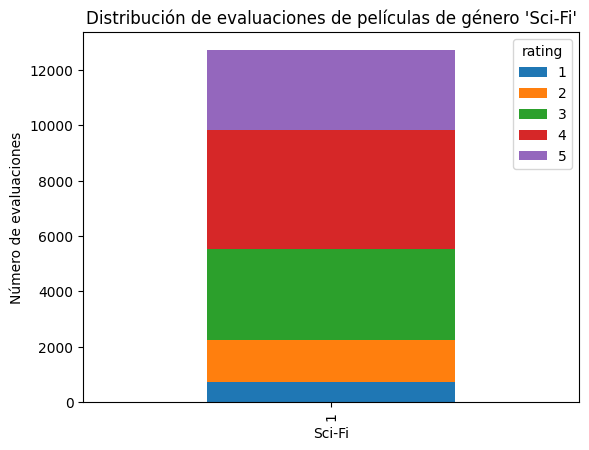

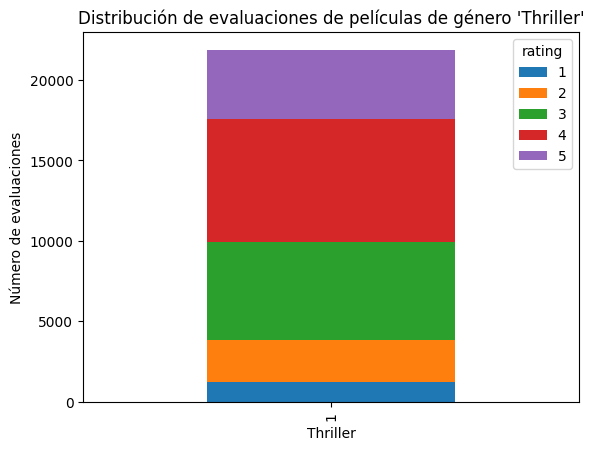

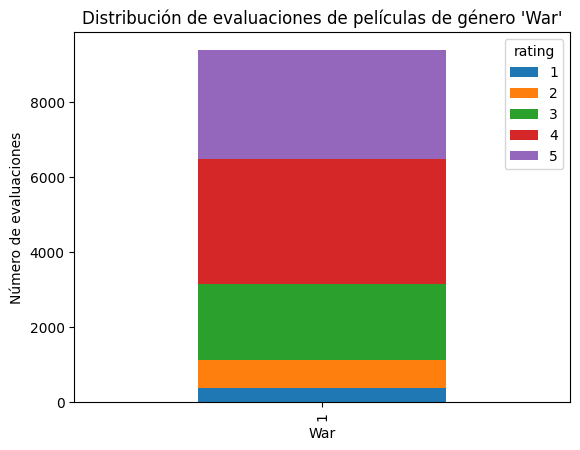

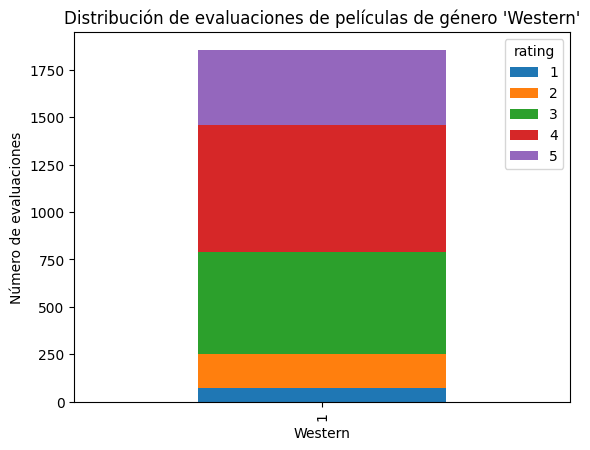

In [ ]:
import matplotlib.pyplot as plt

for genre in u_genre['genre']:
  if (genre == "Children's"):
    genre = "Children"
  ratings_by_genre = data_joined[data_joined[genre] == 1].groupby(genre)['rating'].value_counts()
  ratings_by_genre.unstack().plot(kind='bar', stacked=True)

  plt.xlabel(genre)
  plt.ylabel("Número de evaluaciones")
  plt.title(f"Distribución de evaluaciones de películas de género '{genre}'")


En los gráficos anteriores, se observan las distribuciones de evaluaciones para cada género de película. A partir de estos, se tiene que las películas de Drama, Comedia y Acción son los géneros más evaluados.

## Fase 1: Construcción del modelo de predicción

### Arboles de decisión

Se hacen las importaciones necesarias para poder utilizar el modelo de Desision tree Regressor

In [ ]:
pip install scikit-optimize

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
from skopt.space import Real, Integer

Ya con las importaciones avanzamos con el preprocesamieno de datos

In [ ]:
import pandas as pd
data_joined['release_date'] = pd.to_datetime(data_joined['release_date']).dt.year
data_joined['release_date'] = data_joined['release_date'].astype('int64')
data_joined.head()

,user_id,item_id,rating,timestamp,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,...,Romance,Sci-Fi,Thriller,War,Western,age,gender,occupation,zip_code,release_year
0,196,242,3,881250949,242,Kolya (1996),1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,...,0,0,0,0,0,49,M,writer,55105,1997
1,186,302,3,891717742,302,L.A. Confidential (1997),1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,...,0,0,1,0,0,39,F,executive,00000,1997
2,22,377,1,878887116,377,Heavyweights (1994),1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,...,0,0,0,0,0,25,M,writer,40206,1994
3,244,51,2,880606923,51,Legends of the Fall (1994),1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,...,1,0,0,1,1,28,M,technician,80525,1994
4,166,346,1,886397596,346,Jackie Brown (1997),1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,...,0,0,0,0,0,47,M,educator,55113,1997


In [ ]:
# Preprocesamiento de datos

# se toman los datos no lineales y se hacen lineales
label_encoder = LabelEncoder()
data_joined['gender'] = label_encoder.fit_transform(data_joined['gender'])
data_joined['occupation'] = label_encoder.fit_transform(data_joined['occupation'])
data_joined['movie_title'] = label_encoder.fit_transform(data_joined['movie_title'])
data_joined['video_release_date'] = label_encoder.fit_transform(data_joined['video_release_date'])
data_joined['zip_code'] = label_encoder.fit_transform(data_joined['zip_code'])


# Selección de características
features = ['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'video_release_date', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age', 'gender', 'occupation', 'zip_code']
data = data_joined

# Preparar la matriz de características (X) y el vector objetivo (y)
X = data.drop('rating', axis=1)
y = data['rating']

# Normalización de características
scaler = StandardScaler()
X = scaler.fit_transform(X[features])

Se monta el modelo

In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1, random_state=42)

# Definir el modelo
model = DecisionTreeRegressor()

# Definir los parámetros para la búsqueda bayesiana
param_space = {
    'max_depth': Integer(1, 500),
    'min_samples_split': Integer(2, 800),
    'min_samples_leaf': Integer(1, 800)
}

# Realizar la búsqueda bayesiana
bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=param_space,
    n_iter=64,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Ajustar la búsqueda bayesiana
bayes_search.fit(X, y)

# Mejor modelo
best_model = bayes_search.best_estimator_
print(f"Best parameters: {bayes_search.best_params_}")

# Realizar predicciones con el mejor modelo
y_pred_best = best_model.predict(X)

# Evaluación del mejor modelo con métricas de regresión
mse_best = mean_squared_error(y, y_pred_best)
mae_best = mean_absolute_error(y, y_pred_best)
r2_best = r2_score(y, y_pred_best)

print(f"Best Mean Squared Error (MSE): {mse_best}")
print(f"Best Mean Absolute Error (MAE): {mae_best}")
print(f"Best R^2 Score: {r2_best}")


Best parameters: OrderedDict([('max_depth', 398), ('min_samples_leaf', 110), ('min_samples_split', 20)])
Best Mean Squared Error (MSE): 1.003712410288519
Best Mean Absolute Error (MAE): 0.8021254364398263
Best R^2 Score: 0.2078911789957787


In [ ]:
#Estos son los datos correspondientes al mejor modelo optenido en la sección anterior
optimal_model = DecisionTreeRegressor(
    max_depth=233,
    min_samples_leaf=1,
    min_samples_split=329,
    random_state=42
)
optimal_model.fit(X, y)

DecisionTreeRegressor(max_depth=233, min_samples_split=329, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# Evaluación de Random Forest
rf_mse = mean_squared_error(y, y_pred_rf)
rf_mae = mean_absolute_error(y, y_pred_rf)
rf_r2 = r2_score(y, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest Mean Absolute Error (MAE): {rf_mae}")
print(f"Random Forest R^2 Score: {rf_r2}")

y_pred_rounded = y_pred_rf.round()
accuracy = accuracy_score(y, y_pred_rounded)

print(f"Accuracy: {accuracy}")


Random Forest Mean Squared Error (MSE): 0.1353778770089308
Random Forest Mean Absolute Error (MAE): 0.2897559780380234
Random Forest R^2 Score: 0.8931626136646312
Accuracy: 0.8336850316528488


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X, y)
y_pred_gb = gb_model.predict(X)

# Evaluación de Gradient Boosting
gb_mse = mean_squared_error(y, y_pred_gb)
gb_mae = mean_absolute_error(y, y_pred_gb)
gb_r2 = r2_score(y, y_pred_gb)

print(f"Gradient Boosting Mean Squared Error (MSE): {gb_mse}")
print(f"Gradient Boosting Mean Absolute Error (MAE): {gb_mae}")
print(f"Gradient Boosting R^2 Score: {gb_r2}")

Gradient Boosting Mean Squared Error (MSE): 1.049196893577414
Gradient Boosting Mean Absolute Error (MAE): 0.8265683022142625
Gradient Boosting R^2 Score: 0.17199577702341862


In [ ]:
# Print the predictions
print(y_pred_rf)

[3.16 3.07 1.5  ... 1.89 2.09 2.91]


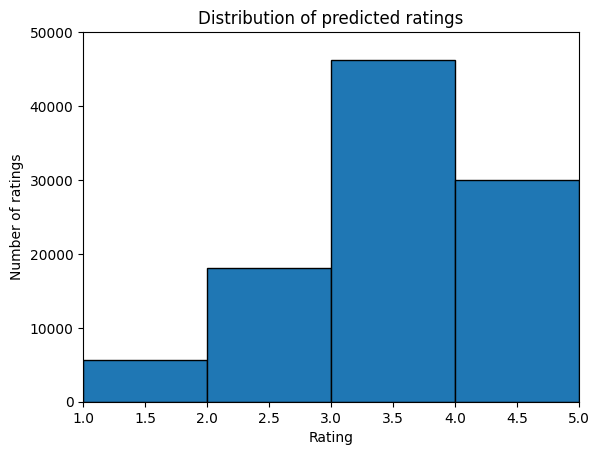

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram with 5 bins
bins = np.linspace(1, 5, 5)

# Plot the histogram
plt.hist(y_pred_rf, bins=bins, edgecolor='black')

# Set the x-axis limits
plt.xlim([1, 5])

# Set the y-axis limits
plt.ylim([0, 50000])

# Set the x-axis label
plt.xlabel('Rating')

# Set the y-axis label
plt.ylabel('Number of ratings')

# Set the title
plt.title('Distribution of predicted ratings')

# Show the plot
plt.show()


In [ ]:
import pandas as pd
rf_importances = rf_model.feature_importances_

# Create a dataframe with feature names and importances
feature_importances_df = pd.DataFrame({
    'feature': features,
    'importance': rf_importances
})

# Sort the dataframe by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the top 5 features
print(feature_importances_df)


               feature  importance
0              user_id    0.182553
27            zip_code    0.179016
24                 age    0.133301
26          occupation    0.089546
3          movie_title    0.081294
2             movie_id    0.072904
1              item_id    0.070876
4         release_date    0.066235
25              gender    0.021408
13               Drama    0.016853
19             Romance    0.009434
10              Comedy    0.009256
21            Thriller    0.008057
6               Action    0.007945
9             Children    0.007314
16              Horror    0.006402
7            Adventure    0.005874
22                 War    0.005226
20              Sci-Fi    0.005124
11               Crime    0.004829
17             Musical    0.004471
8            Animation    0.002856
18             Mystery    0.002755
15           Film-Noir    0.002291
12         Documentary    0.001716
23             Western    0.001392
14             Fantasy    0.001071
5   video_release_da

### Modelo random forest post vista de caracteristicas


In [ ]:
# Preprocesamiento de datos

# se toman los datos no lineales y se hacen lineales
label_encoder = LabelEncoder()
data_joined['occupation'] = label_encoder.fit_transform(data_joined['occupation'])
data_joined['movie_title'] = label_encoder.fit_transform(data_joined['movie_title'])
data_joined['release_date'] = label_encoder.fit_transform(data_joined['release_date'])
data_joined['zip_code'] = label_encoder.fit_transform(data_joined['zip_code'])

# Selección de características
features = ['user_id', 'item_id', 'movie_id', 'movie_title', 'age', 'occupation', 'zip_code', 'release_date', 'gender']
data = data_joined

# Preparar la matriz de características (X) y el vector objetivo (y)
X = data.drop('rating', axis=1)
y = data['rating']

# Normalización de características
scaler = StandardScaler()
X = scaler.fit_transform(X[features])


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# Evaluación de Random Forest
rf_mse = mean_squared_error(y, y_pred_rf)
rf_mae = mean_absolute_error(y, y_pred_rf)
rf_r2 = r2_score(y, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest Mean Absolute Error (MAE): {rf_mae}")
print(f"Random Forest R^2 Score: {rf_r2}")

y_pred_rounded = y_pred_rf.round()
accuracy = accuracy_score(y, y_pred_rounded)

print(f"Accuracy: {accuracy}")


Random Forest Mean Squared Error (MSE): 0.13908917402566232
Random Forest Mean Absolute Error (MAE): 0.29357302157194143
Random Forest R^2 Score: 0.8902337357567904
Accuracy: 0.8274644718024622


In [ ]:
import pandas as pd
rf_importances = rf_model.feature_importances_

# Create a dataframe with feature names and importances
feature_importances_df = pd.DataFrame({
    'feature': features,
    'importance': rf_importances
})

# Sort the dataframe by importance in descending order
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Print the top 5 features
print(feature_importances_df)


        feature  importance
0       user_id    0.177709
6      zip_code    0.175743
4           age    0.130983
3   movie_title    0.125601
2      movie_id    0.103924
1       item_id    0.101277
5    occupation    0.087878
7  release_date    0.076342
8        gender    0.020543


### Redes neuronales

Durante esta primera fase del proyecto la intención es comparar árboles de decisión con otro modelo de predicción. En conjunto decidimos emplear redes neuronales ya que según la literatura son un buen modelo cuando se busca hacer predicción tanto binaria como multiclase. Para esta evaluación se va a tomar la variable meta como el rating y las variables predictoras el usuario, su ocupación, edad, y género; igualmente la película, su fecha de lanzamiento y su género. A continuación se procede a tomar estos datos del conjunto de datos original.

In [ ]:
label_encoder = LabelEncoder()
data_joined['occupation'] = label_encoder.fit_transform(data_joined['occupation'])
data_joined['movie_title'] = label_encoder.fit_transform(data_joined['movie_title'])
data_joined['release_date'] = label_encoder.fit_transform(data_joined['release_date'])
data_joined['zip_code'] = label_encoder.fit_transform(data_joined['zip_code'])

features = ['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'age', 'occupation', 'zip_code', 'gender']

data = data_joined[features + ['rating']]

X = data.drop('rating', axis=1)
y = data['rating'].map(lambda x: x - 1)

print("Variable meta: rating")
print(y[:5])

print(f"Variables predictoras: {features}")
X.head()

Variable meta: rating
0    2
1    2
2    0
3    1
4    0
Name: rating, dtype: int64
Variables predictoras: ['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'age', 'occupation', 'zip_code', 'gender']


,user_id,item_id,movie_id,movie_title,release_date,age,occupation,zip_code,gender
0,196,242,242,825,69,49,20,415,1
1,186,302,302,829,69,39,6,0,0
2,22,377,377,673,66,25,20,311,1
3,244,51,51,857,66,28,19,591,1
4,166,346,346,767,69,47,3,420,1


Ya que se va a trabajar con redes neuronales se debe de hacer un pre procesamiento de datos que conlleva estandarizarlos para que se muestren en una sola escala. Esto se hace con el fin de mejorar el rendimiento de las predicciones realizadas.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for column in X.columns:
  column_scaler = scaler.fit(X[column].values.reshape(-1, 1))
  X[column] = column_scaler.transform(X[column].values.reshape(-1, 1))

X.head()

,user_id,item_id,movie_id,movie_title,release_date,age,occupation,zip_code,gender
0,-0.999578,-0.554836,-0.554836,0.000793,0.639320,1.386309,1.347418,0.040798,0.588749
1,-1.037086,-0.373462,-0.373462,0.009108,0.639320,0.521469,-0.766477,-1.800297,-1.698516
2,-1.652215,-0.146745,-0.146745,-0.315191,0.427168,-0.689307,1.347418,-0.420585,0.588749
3,-0.819540,-1.132210,-1.132210,0.067316,0.427168,-0.429855,1.196426,0.821599,0.588749
4,-1.112102,-0.240455,-0.240455,-0.119780,0.639320,1.213341,-1.219454,0.062980,0.588749


A partir de estos datos se genera un conjunto de entrenamiento y otro de pruebas con el siguiente código.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

El modelo de la red neuronal va a ser un modelo multiclase compuesta por las distintas opciones de evaluaciones disponibles. Para usar el modelo de esta forma se debe de convertir la variable meta a una variable categórica con el siguiente código.

In [ ]:
from keras.utils import to_categorical

y_train_categorical = to_categorical(y_train, num_classes = 5)
y_test_categorical = to_categorical(y_test, num_classes = 5)

Posteriormente procedemos a construir la red neuronal. Para esto se va a definir una única entrada que corresponde a las variables predictoras definidas incialmente. Esta entrada es de 23 dimensiones. A partir de esta entrada se definirán 3 capas ocultas, la primera de 20 neuronas, la siguiente de 15 y la ultima de 10 neuronas. Estas capas ocultas usarán una función de activación llamada *tanh* ya que no son datos separables linealmente y por el contrario buscamos hiperplanos para separarlos. Posterior a estas 3 capas ocultas, se usará una capa de salida de 5 neuronas con la función de activación *softmax*, con ello buscamos que el modelo nos dé la probabilidad de cada una de las 5 evaluaciones de acuerdo a la entrada dada y a las capas anteriores. Para entrenar el modelo se uso el optimizador *ADAM* y la función de perdida *categorical_focal_crossentropy* ya que estos presentan buenos resultados para datos con clases no balanceadas. Igualmente, para la evaluación se usaron las medidas MAE y MSE. A continuación se muestra el código con el que se generó esta red.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

def create_model(optimizer='adam', neurons=20, activation='tanh'):
    model_input = Input(shape=[X_train.shape[1]], name='input')

    dense = Dense(neurons, activation=activation, name='dense')(model_input)
    dense1 = Dense(neurons//2, activation=activation, name='dense1')(dense)
    dense2 = Dense(neurons//4, activation=activation, name='dense2')(dense1)
    dense3 = Dense(neurons//8, activation=activation, name='dense3')(dense2)
    output = Dense(5, activation='softmax', name='output')(dense3)

    model = Model(inputs=model_input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['mae', 'mse'])#categorical_focal_crossentropy
    return model

A partir de este modelo podemos ahora entrenar el modelo con nuestros datos y evaluar como se comporta.

In [ ]:
# Crear el modelo
model = create_model(neurons=128)

# Entrenar el modelo
history = model.fit(X_train,
                    y_train_categorical,
                    epochs=10,
                    batch_size=10,
                    validation_data=(X_test, y_test_categorical),
                    verbose=1)

Epoch 1/10
8000/8000 [==============================] - 39s 4ms/step - loss: 1.4384 - mae: 0.2942 - mse: 0.1478 - val_loss: 1.4283 - val_mae: 0.2931 - val_mse: 0.1471
Epoch 2/10
8000/8000 [==============================] - 36s 4ms/step - loss: 1.4238 - mae: 0.2926 - mse: 0.1466 - val_loss: 1.4235 - val_mae: 0.2928 - val_mse: 0.1466
Epoch 3/10
8000/8000 [==============================] - 37s 5ms/step - loss: 1.4142 - mae: 0.2912 - mse: 0.1458 - val_loss: 1.4130 - val_mae: 0.2905 - val_mse: 0.1459
Epoch 4/10
8000/8000 [==============================] - 36s 4ms/step - loss: 1.4049 - mae: 0.2898 - mse: 0.1451 - val_loss: 1.4081 - val_mae: 0.2918 - val_mse: 0.1454
Epoch 5/10
8000/8000 [==============================] - 37s 5ms/step - loss: 1.3943 - mae: 0.2883 - mse: 0.1443 - val_loss: 1.3979 - val_mae: 0.2887 - val_mse: 0.1446
Epoch 6/10
8000/8000 [==============================] - 39s 5ms/step - loss: 1.3857 - mae: 0.2869 - mse: 0.1436 - val_loss: 1.3961 - val_mae: 0.2869 - val_mse: 0.144

Para evaluar la certeza del modelo se procede a usar los datos de prueba para generar predicciones y mostrar en una matriz de confusión los resultados.

625/625 [==============================] - 2s 2ms/step


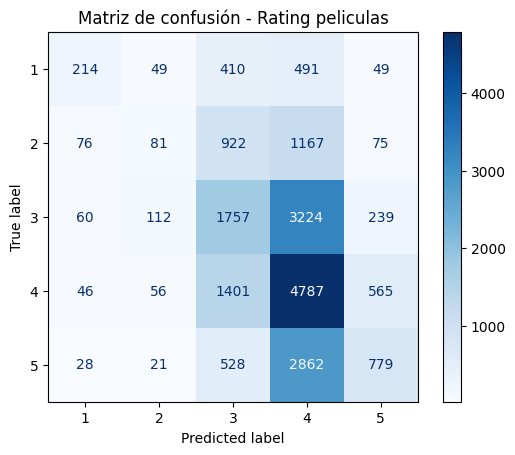

              precision    recall  f1-score   support

           0       0.50      0.18      0.26      1213
           1       0.25      0.03      0.06      2321
           2       0.35      0.33      0.34      5392
           3       0.38      0.70      0.49      6855
           4       0.46      0.18      0.26      4218

    accuracy                           0.38     19999
   macro avg       0.39      0.28      0.28     19999
weighted avg       0.38      0.38      0.34     19999



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)

y_pred_ratings = []
for index, pred in enumerate(y_pred):
  y_pred_ratings.append(np.argmax(pred))

conf_matrix = confusion_matrix(y_test, y_pred_ratings)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= ["1", "2", "3", "4", "5"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de confusión - Rating peliculas')
plt.show()

print(classification_report(y_test, y_pred_ratings))

Como se puede ver, los resultados anteriores no dan los mejores resultados. Un motivo que puede causar esto es el ajuste de hiperparámetros de la red. Para conseguir estos valores se procede a crear distintas redes con distintos parametros para identificar el mejor conjunto de parametros.

In [ ]:
epochs = [5, 10, 25, 50]
batch_size = [5, 10, 25, 50]

for batch_size_trial in batch_size:
  for epochs_trial in epochs:
    model_data = model.fit(x=X_train, y=y_train_categorical, epochs=epochs_trial, batch_size=batch_size_trial, validation_data=(X_test, y_test_categorical), verbose=0)
    # Fetching the accuracy of the training
    loss = model_data.history['loss'][-1]
    mae = model_data.history['mae'][-1]
    mse = model_data.history['mae'][-1]

    # printing the results of the current iteration
    print('Parameters:','batch_size:', batch_size_trial,'\t\t', 'epochs:',epochs_trial, '\tMSE:', mse,'\t\tLoss:', loss, '\t\tMAE:', mae)

KeyboardInterrupt: 

## Fase 2

Como parte de la segunda fase del actual proyecto se pretende construir un sistema de recomendación sobre el mismo conjunto de datos de MovieLens. Con este sistema de recomendación se espera ser capaz de recomendar películas a un usuario de acuerdo a sus gustos. Para construir este sistema se va a utilizar tanto árboles de decisión al haber obtenido buenos resultados en la fase anterior y se agregará el modelo de k-nearest neighbors para con ello buscar similitudes entre usuarios y películas.

Para empezar con el siguiente código podemos ver la cantidad de películas y usuarios que hay en el conjunto de datos.

In [ ]:
print(
    'Se cuenta con',
    u_user['user_id'].nunique(),
    'usuarios distintos y con',
    u_item['movie_id'].nunique(),
    'peliculas distintas')

Se cuenta con 943 usuarios distintos y con 1681 peliculas distintas


A partir de estos datos y del analisis exploratorio realizado anteriormente sabemos que hay usuarios que no han hecho muchas evaluaciones y otros usuarios que han hecho muchas evaluaciones. Para mostrar esto podemos usar el siguiente código para ver un gráfico de cajas con la cantidad de evaluaciones por cada usuario.

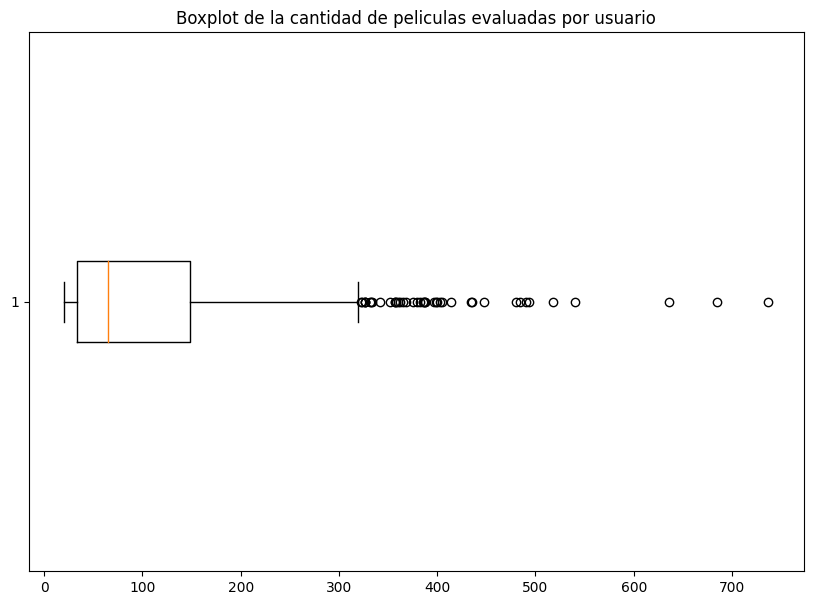

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
plt.boxplot(data_joined.groupby('user_id')['rating'].count(), vert=False)
plt.title("Boxplot de la cantidad de peliculas evaluadas por usuario")
plt.show()

A partir de este gráfico anterior vemos que muchos usuarios tiene una cantidad de evaluaciones superiores a 320; mientras que la mayoría tiene entre 33 a 320 evaluaciones. Debido a esta distribución decidimos eliminar algunos de los valores extremos utilizando el algoritmo del rango intercuartilico. Con esto vamos a eliminar datos con muy pocas evaluaciones y con muchas. Para hacer esto podemos usar el siguiente código.

In [ ]:
import numpy

user_counts = data_joined.groupby('user_id')['rating'].count()
q1, q3 = numpy.percentile(user_counts, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}")
print(f"Count of ratings per user: [{lower_bound}, {upper_bound}]")
users_to_drop = user_counts[(user_counts[user_counts > upper_bound])].index
data_joined = data_joined[~data_joined['user_id'].isin(users_to_drop)]

Q1: 33.0, Q3: 148.0, IQR: 115.0
Count of ratings per user: [-139.5, 320.5]


In [ ]:
data_joined.shape

(95274, 33)

A partir de este filtro quedamos con 95274 datos que utilizaremos.

Igualmente, a continuación eliminamos algunas columnas que no nos interesan. Y nos aseguramos que no tenemos datos nulos.

In [ ]:
data_joined.drop(['video_release_date', 'IMDb_URL'], axis = 1, inplace = True)

<ipython-input-18-0257e95aedc4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_joined.drop(['video_release_date', 'IMDb_URL'], axis = 1, inplace = True)


In [ ]:
data_joined.isnull().any()

user_id         False
item_id         False
rating          False
timestamp       False
movie_id        False
movie_title     False
release_date    False
unknown         False
Action          False
Adventure       False
Animation       False
Children        False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
age             False
gender          False
occupation      False
zip_code        False
release_year    False
dtype: bool

### Creación de matrices

Antes de empezar a construir el sistema de recomendacion nos interesa visualizar la cantidad de películas que no tiene una evaluación para cada uno de los usuarios y las películas para luego usar modelos de predicción para completar estos datos faltantes. Para hacer esto construiremos una matriz donde vamos a poder visualizar la calificación que cada uno de los usuarios le ha dado a cada una de las películas.

(904, 1651)
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2          4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

movie_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                               
1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5          0.0   0.0  

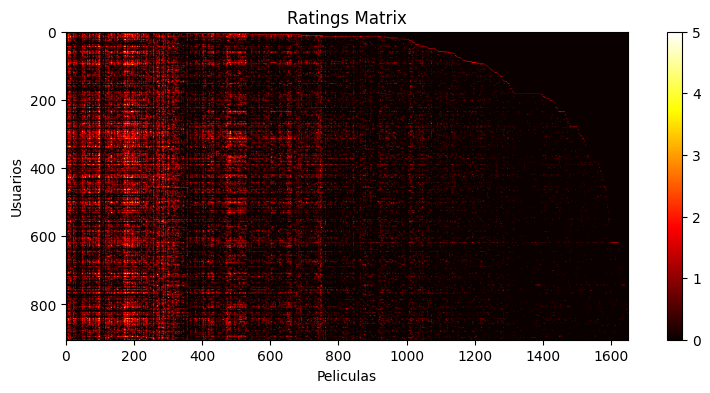

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ratings = data_joined[['user_id', 'movie_id', 'rating']]

# Crear la matriz de calificaciones
ratings_matrix = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

print(ratings_matrix.shape)
print(ratings_matrix.head())

# grafico
plt.figure(figsize=(10, 4))
plt.imshow(ratings_matrix, cmap='hot')
plt.title('Ratings Matrix')
plt.xlabel("Peliculas")
plt.ylabel("Usuarios")
plt.colorbar()
plt.show()

Con estos datos podemos ver que aún hay muchos datos faltantes. Para completar estos datos empezaremos usando árboles de decisión para completar los datos y luego generar recomendaciones.

### Modelo de arboles para completar datos faltantes


Para construir el árboles empezamos por hacer un pre procesamiento a los datos para posteriormente construir el árbol usando RandomForestRegressor ya que fue el que nos generó los mejores resultados en la fase anterior.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Preprocesamiento de datos

# se toman los datos no lineales y se hacen lineales
label_encoder = LabelEncoder()
data_joined['occupation'] = label_encoder.fit_transform(data_joined['occupation'])
data_joined['movie_title'] = label_encoder.fit_transform(data_joined['movie_title'])
data_joined['release_date'] = label_encoder.fit_transform(data_joined['release_date'])
data_joined['zip_code'] = label_encoder.fit_transform(data_joined['zip_code'])

# Selección de características
features = ['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'age', 'occupation', 'zip_code', 'timestamp']
data = data_joined[features + ['rating']]

# Preparar la matriz de características (X) y el vector objetivo (y)
X = data.drop('rating', axis=1)
y = data['rating']

# Normalización de características
scaler = StandardScaler()
X = scaler.fit_transform(X[features])

<ipython-input-21-0495d1bf483f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_joined['occupation'] = label_encoder.fit_transform(data_joined['occupation'])
<ipython-input-21-0495d1bf483f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_joined['movie_title'] = label_encoder.fit_transform(data_joined['movie_title'])
<ipython-input-21-0495d1bf483f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# Evaluación de Random Forest
rf_mse = mean_squared_error(y, y_pred_rf)
rf_mae = mean_absolute_error(y, y_pred_rf)
rf_r2 = r2_score(y, y_pred_rf)

print(f"Random Forest Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest Mean Absolute Error (MAE): {rf_mae}")
print(f"Random Forest R^2 Score: {rf_r2}")

y_pred_rounded = y_pred_rf.round()
accuracy = accuracy_score(y, y_pred_rounded)

print(f"Accuracy: {accuracy}")

Random Forest Mean Squared Error (MSE): 0.1348733180091106
Random Forest Mean Absolute Error (MAE): 0.2891161282196612
Random Forest R^2 Score: 0.8914731102640934
Accuracy: 0.8346138505783319


Una vez que se genera el árbol se procede a generar una matriz con los datos faltantes para posteriormente utilizarla para hacer recomendaciones. Esto se hace con el código a continuación.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Entrenar el StandardScaler con las características existentes
scaler = StandardScaler()
features = ['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'age', 'occupation', 'zip_code', 'timestamp']
scaler.fit(data_joined[features])

# Convertir la matriz de calificaciones a formato largo
ratings_long = ratings_matrix.stack().reset_index()
ratings_long.columns = ['user_id', 'movie_id', 'rating']

# Encontrar todas las posiciones con valor 0
zeros_positions = ratings_long[ratings_long['rating'] == 0][['user_id', 'movie_id']]

# Unir datos de usuario basados en user_id
user_features = data_joined[['user_id', 'age', 'occupation']].drop_duplicates()
zeros_positions = zeros_positions.merge(user_features, on='user_id', how='left')

# Unir datos de película basados en movie_id
movie_features = data_joined[['movie_id', 'item_id', 'movie_title', 'release_date', 'zip_code', 'timestamp']].drop_duplicates()
zeros_positions = zeros_positions.merge(movie_features, on='movie_id', how='left')

# Normalizar las características
X_missing = scaler.transform(zeros_positions[['user_id', 'item_id', 'movie_id', 'movie_title', 'release_date', 'age', 'occupation', 'zip_code', 'timestamp']])

# Realizar predicciones para los valores faltantes
y_missing_pred = rf_model.predict(X_missing)

# Asignar las predicciones a los valores faltantes en la matriz de ratings
for i, (user_id, movie_id) in enumerate(zip(zeros_positions['user_id'], zeros_positions['movie_id'])):
    ratings_matrix.loc[user_id, movie_id] = y_missing_pred[i]

# Verificar la matriz de ratings completada
print(ratings_matrix.head())


El proceso anterior es pesado y lento por lo que se decide guardar una copia local del resultado. Habría que arreglar esta dirección para que funcione en cada máquina

In [ ]:
import pandas as pd
#ratings_matrix.to_csv('/content/drive/My Drive/IA_Compartida/Proyecto 2 y 3/ml-100k/ratings_matrix.csv')

# Leer el archivo CSV desde Google Drive
ratings_matrix_l = pd.read_csv('/content/drive/My Drive/IA_Compartida/Proyecto 2 y 3/ml-100k/ratings_matrix.csv', index_col=[0])

# Mostrar las primeras filas de la matriz de ratings
print(ratings_matrix_l.head())

            1     2     3     4     5     6     7     8     9    10  ...  \
user_id                                                              ...   
1        5.00  3.00  4.00  3.00  3.00  5.00  4.00  1.00  5.00  3.00  ...   
4        3.47  3.16  3.68  3.41  3.41  3.63  3.34  3.43  3.91  3.48  ...   
5        4.00  3.00  3.35  3.60  3.26  3.40  3.39  3.74  3.88  3.69  ...   
6        4.00  3.44  3.29  3.69  3.18  2.88  2.00  4.00  4.00  3.62  ...   
7        3.42  3.67  3.67  5.00  3.39  3.17  5.00  5.00  5.00  4.00  ...   

         1668  1669  1670  1672  1674  1675  1676  1677  1681  1682  
user_id                                                              
1        3.32  3.41  3.22  3.20  3.19  3.42  3.07  3.32  3.35  3.18  
4        3.32  3.41  3.22  3.20  3.19  3.42  3.07  3.32  3.35  3.18  
5        3.36  3.48  3.32  3.38  3.50  3.00  3.16  3.26  3.45  3.17  
6        3.16  3.40  3.39  3.52  3.50  2.76  2.89  3.09  3.17  2.97  
7        3.38  3.51  3.56  3.15  3.31  3.13  3.

Una vez que ya se genera la matriz con los datos faltantes se procede a mostrarla a continuación en un gráfico.

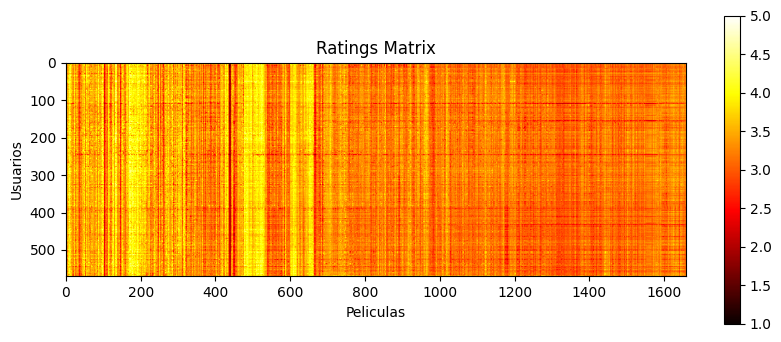

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(ratings_matrix_l, cmap='hot')
plt.title('Ratings Matrix')
plt.xlabel("Peliculas")
plt.ylabel("Usuarios")
plt.colorbar()
plt.show()

Una vez con esta matriz generada se pueden hacer recomendaciones. Para esto se busca un usuario en la matriz y se buscan las películas que no ha evaluado para tomar en top n de esta películas no evaluadas y así obtener las recomendaciones. Esto se hace con el siguiente código.

In [ ]:
# Generacion de recomendacion
user_id = 431
top = 5
rated_movies = data_joined[data_joined['user_id'] == user_id]['item_id'].values
missing_movies = dict()

movies = ratings_matrix_l.iloc[user_id]

for movie in range(len(movies)):
  if movie not in rated_movies:
    missing_movies[movie + 1] = movies[movie]

sorted_movies = dict(sorted(missing_movies.items(), key = lambda item: item[1], reverse = True))

values = list(map(lambda movie_id: (u_item[u_item['movie_id'] == movie_id]['movie_title'])[movie_id - 1], list(sorted_movies.keys())[:top]))

print(values)

['Independence Day (ID4) (1996)', 'Willy Wonka and the Chocolate Factory (1971)', 'Cop Land (1997)', 'Kiss the Girls (1997)', 'Freeway (1996)']


### Resto de las matrices

Una vez que ya se han completado estos datos se pueden buscar la similitudes entre usuarios y películas para mostrarlos en una matriz. Esto se hace con el código a continuación usando la comparación pearson.

user_id       1         4         5         6         7         9         10   \
user_id                                                                         
1        1.000000  0.752071  0.515518  0.459499  0.386638  0.680080  0.467604   
4        0.752071  1.000000  0.572023  0.508037  0.419495  0.811302  0.560321   
5        0.515518  0.572023  1.000000  0.580240  0.402197  0.605793  0.543253   
6        0.459499  0.508037  0.580240  1.000000  0.555948  0.619696  0.715575   
7        0.386638  0.419495  0.402197  0.555948  1.000000  0.558014  0.692938   

user_id       11        13        17   ...       926       928       929  \
user_id                                ...                                 
1        0.479713  0.362873  0.667128  ...  0.480016  0.451852  0.456883   
4        0.538276  0.373480  0.793198  ...  0.564814  0.530554  0.533010   
5        0.600279  0.472853  0.633007  ...  0.503431  0.370337  0.456562   
6        0.630052  0.540142  0.623537  ...  0.605960

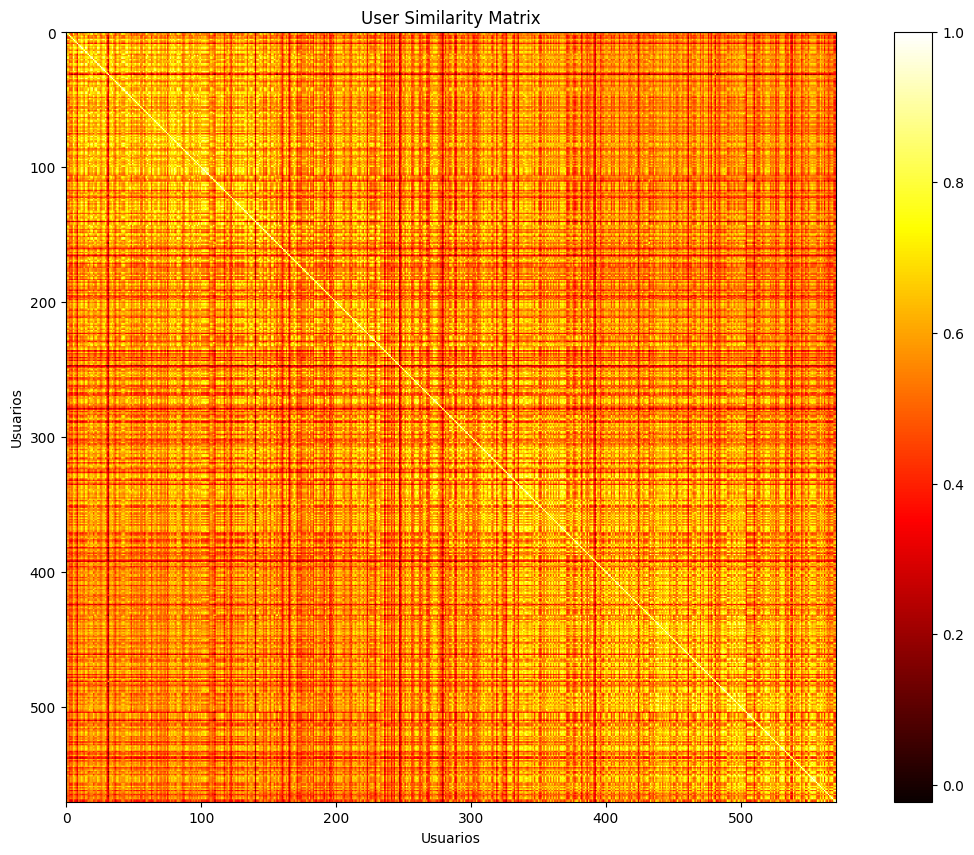

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Calcular la similitud de pearson entre los usuarios
user_similarity_df = ratings_matrix_l.T.corr(method='pearson')

print(user_similarity_df.head())

plt.figure(figsize=(15, 10))
plt.imshow(user_similarity_df, cmap='hot')
plt.title('User Similarity Matrix')
plt.xlabel("Usuarios")
plt.ylabel("Usuarios")
plt.colorbar()
plt.show()


          1         2         3         4         5         6         7  \
1  1.000000  0.119325  0.052800  0.049898  0.137883  0.181199  0.187461   
2  0.119325  1.000000  0.220018  0.334591  0.207624  0.005132  0.068468   
3  0.052800  0.220018  1.000000  0.067126  0.203269  0.113790  0.000341   
4  0.049898  0.334591  0.067126  1.000000  0.032898  0.020599  0.057367   
5  0.137883  0.207624  0.203269  0.032898  1.000000 -0.022355 -0.019518   

          8         9        10  ...      1668      1669      1670      1672  \
1  0.044050  0.109072  0.184842  ...  0.025386  0.034701 -0.033509 -0.002642   
2  0.254326  0.030930  0.102505  ...  0.253755  0.185018  0.298793  0.277085   
3  0.054949  0.056451  0.043203  ...  0.135240  0.059664  0.146067  0.195698   
4  0.295084  0.150661  0.118467  ...  0.193438  0.110169  0.209507  0.213884   
5  0.186636  0.209671  0.065603  ...  0.110481  0.121568  0.042403  0.304743   

       1674      1675      1676      1677      1681      1682  
1  0

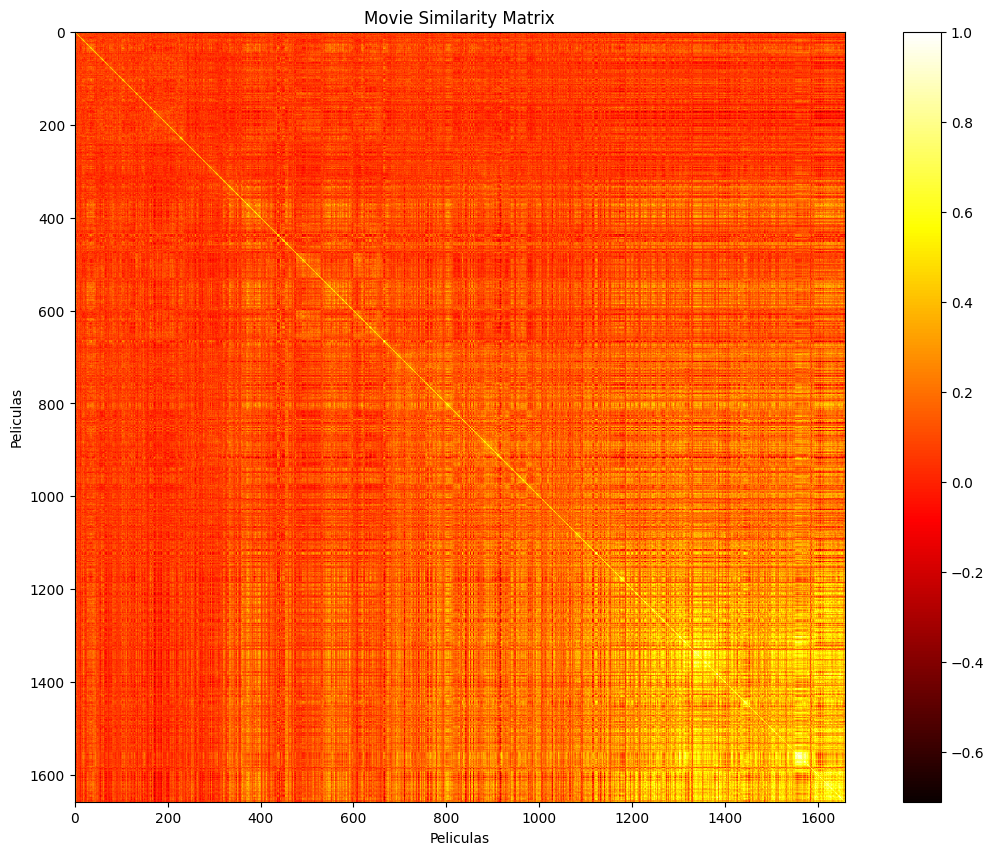

In [ ]:
# Calcular la similitud de coseno entre las películas
#movie_similarity = cosine_similarity(ratings_matrix_l.T)
#movie_similarity_df = pd.DataFrame(movie_similarity, index=ratings_matrix_l.columns, columns=ratings_matrix_l.columns)

# Calcular la similitud de pearson entre los peliculas
movie_similarity_df = ratings_matrix_l.corr(method='pearson')

print(movie_similarity_df.head())

# Crear un gráfico de la similitud de las películas
plt.figure(figsize=(15, 10))
plt.imshow(movie_similarity_df, cmap='hot')
plt.title('Movie Similarity Matrix')
plt.xlabel("Peliculas")
plt.ylabel("Peliculas")
plt.colorbar()
plt.show()


A partir de estos dos gráficos, el primero de usuarios y el siguiente de películas, podemos ver que a partir del modelo de árboles las similitudes se presentan más entre usuarios que entre películas.

### Modelo de k-nearest neighbors

Como parte del segundo modelo de recomendación se va a usar el algoritmo de k-nearest neighbors para buscar similitudes ya sea entre películas o entre usuarios para posteriormente realizar recomendaciones. A continuación se instala una de las librerías necesarias para usar estos algoritmos en sistemas de recomendación.

In [ ]:
!pip install surprise

Una vez que tenemos esta librería instalada procedemos a preparar los datos. Para ello generamos el conjunto de datos que será, similar al caso anterior, una matriz con de los usuarios y las películas. A continuación se muestra el código para hacer esto.

In [ ]:
from sklearn.model_selection import train_test_split as train_test_split_sklearn

data_tuning = data_joined[['user_id', 'item_id', 'rating']].sort_values(by = 'rating').reset_index(drop=True).rename(columns={'user_id': 'userId', 'item_id': 'movieId', 'rating': 'ratings'})

data_tuning.head()

data_tuning_train, data_tuning_test = train_test_split_sklearn(data_tuning, test_size= 0.2)

In [ ]:
import surprise

reader = surprise.Reader(rating_scale=(1, 3))
data = surprise.Dataset.load_from_df(data_tuning, reader)

type(data)

surprise.dataset.DatasetAutoFolds

Una vez que se tiene el conjunto de datos se procede a generar el conjunto de entrenamiento y el de prueba para identificar si las similitudes son mejores entre usuarios o entre películas. Para hacer esto se usa el código mostrado a continuación.

In [ ]:
from surprise.model_selection.split import train_test_split

trainset, testset = train_test_split(data, test_size=0.1, random_state=24)

type(trainset)

surprise.trainset.Trainset

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic

sim_options = {'name': 'pearson',
               'user_based': False}

algo_knn_basic = KNNBasic(sim_options=sim_options)

predictions = algo_knn_basic.fit(trainset).test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
from surprise import accuracy

mae_model = accuracy.mae(predictions)
rmse_model = accuracy.rmse(predictions)

MAE:  1.0058
RMSE: 1.2366


A partir de esto podemos ver que para las similitudes a nivel de película se obtuvo un RMSE de 1.2366 y un MAE de 1.0058 usando una similitud de pearson. A continuación se hace lo mismo pero buscando las similitudes por usuario.

In [ ]:
sim_options = {'name': 'pearson',
               'user_based': True}

algo_knn_basic = KNNBasic(sim_options=sim_options)

predictions = algo_knn_basic.fit(trainset).test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
mae_model = accuracy.mae(predictions)
rmse_model = accuracy.rmse(predictions)

MAE:  1.0034
RMSE: 1.2339


A partir de los datos anteriores podemos ver que al buscar las similitudes por medio de los usuarios se tiene un RMSE de 1.2339 y un MAE de 1.0034. Estos datos sugieren que es mejor buscar similitudes por usuarios que por películas, similar a lo obtenido por los árboles de decisión.

Sin embargo, antes de generar el sistema de recomendación es necesario usar un Grid Search para encontrar la mejor configuración de hiperparametros para el modelo. Esto se puede hacer con el código a continuación.

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {
    'k': [10, 15, 30],
    'min_k': [3, 5, 7],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],
        'user_based': [True, False]
    },
    'verbose': [False]
}

fold_grid_item = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv = 5)

fold_grid_item.fit(data)

print(fold_grid_item.best_score['rmse'])
print(fold_grid_item.best_params['rmse'])

1.2248866146148722
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}, 'verbose': False}


A partir del grid search anterior podemos ver la major combinación de hiperparametros. En el código anterior se usan estos parametros para entrenar de nuevo el modelo, pero esta vez con todo el conjunto de datos.

In [ ]:
train_set = data.build_full_trainset()

sim_options = {'name': 'msd',
               'user_based': False}

algo_knn_basic = KNNBasic(sim_options=sim_options, k = 30, min_k = 3)

algo_knn_basic.fit(train_set)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
from surprise import accuracy

mae_model = accuracy.mae(predictions)
rmse_model = accuracy.rmse(predictions)

MAE:  1.0034
RMSE: 1.2339


A partir de los resultados anteriores podemos ver que en esta ocasión el MAE es de 1.0034 y el RMSE de 1.2339.

A partir de este modelo podemos hacer recomendacioes para un usuario a partir de su identificador y buscando las películas más similares entre ellas para así ser capaces de brindar una recomendación. Muy similar que en árboles, lo que se hace es que se buscan las películas para cada uno de los usuarios que no han sido evaluadas, se evaluan usando el modelo y luego el top n se obtiene tras obtener las películas con las calificaciones más altas. El código para hacer esto se muestra a continuación.

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n = 10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
train_set = data.build_full_trainset()
test_set = train_set.build_anti_testset()

algo_knn_basic.fit(train_set)
predictions = algo_knn_basic.test(test_set)

accuracy.rmse(predictions, verbose = True)
accuracy.mae(predictions, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.6188
MAE:  0.5942


0.594201945369826

A partir de los datos anteriores podemos ver que el RMSE para el sistema de recomendación es 0.6188 y el MAE de 0.5942.

In [ ]:
top_n = 10
top_pred = get_top_n(predictions, n = top_n)

In [ ]:
uid_list = [431]

for uid, user_ratings in top_pred.items():
    if uid in uid_list:
        for (iid, rating) in user_ratings:
            movie = u_item[u_item['movie_id'] == iid]['movie_title'].values[0]
            print('Movie:', iid, '-', movie)

Movie: 396 - Serial Mom (1994)
Movie: 1063 - Little Princess, A (1995)
Movie: 762 - Beautiful Girls (1996)
Movie: 284 - Tin Cup (1996)
Movie: 122 - Cable Guy, The (1996)
Movie: 1335 - American Buffalo (1996)
Movie: 683 - Rocket Man (1997)
Movie: 687 - McHale's Navy (1997)
Movie: 240 - Beavis and Butt-head Do America (1996)
Movie: 17 - From Dusk Till Dawn (1996)
